## Finite Element Method (FEM) discretization of the heat equation in two dimensions with FEniCS

<b>Goal</b>: This <a href="https://jupyter.org"> Jupyter</a> notebook aims at illustrating the use of FEniCS to discretize a time-dependent PDE (heat equation in two dimensions). We specifically learn how to define the problem inside FEniCS. 

<b>Note</b>: a cell is made active by first clicking on the left part of the web page (a blue vertical line appears) and then pushing Shift+Enter. 

<b>Note</b>: The next cell has to be activated only once and specifies the Python libraries we will use in this notebook. A basic knowledge of Python is only expected to understand the code used in the cells.  

In [1]:
#
# To allow plots within the Notebook 
#
%matplotlib inline

# Import here the standard Python libraries used in the Notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy import *
import scipy.sparse as sps
import sys
import time

# Import FEniCS related libraries
from fenics import *
import dolfin as df

### Python version

In [2]:
print(sys.version)

3.7.3 | packaged by conda-forge | (default, Mar 27 2019, 15:43:19) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


### <a href="https://fenicsproject.org">FEniCS</a> version 

In [3]:
print(df.__version__)

2019.1.0


### <a href="https://fenicsproject.org">Scipy</a> Linear algebra libraries

In [4]:
print(show_config())

mkl_info:
  NOT AVAILABLE
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
lapack_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
blas_mkl_info:
  NOT AVAILABLE
system_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
blas_opt_info:
    libraries = ['blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack', 'blas', 'cblas', 'lapack']
    library_dirs = ['/Users/vasseur/Software/anaconda3/envs/fenicsproject/lib']
    language = f77
None


# A.  2D heat equation:


We consider the two-dimensional heat equation defined for all $t\ge 0$ as
$$
\begin{array}{ll} 
    \displaystyle \frac{\partial}{\partial t} u(t,\boldsymbol x) - \text{div}\Big(\overline{\overline k}(\boldsymbol x)\cdot {grad} \ u(t,\boldsymbol x)\Big)&=& 0 , \quad \boldsymbol x \in \Omega, \\
     {\partial_n} u(t,\boldsymbol x) & = & 0, \quad \boldsymbol x \in \partial \Omega, \\ 
    u(0, \boldsymbol x) & = & u_0(x), \quad \boldsymbol x \in \Omega, t=0,  \\
\end{array}
$$
with $\Omega \subset \mathbb{R}^2$ an open bounded spatial domain with Lipschitz-continuous boundary $\delta \Omega$. 

$u(t,\boldsymbol x)$ denotes the temperature from the equilibrium position at point $\boldsymbol x \in \Omega $ and time $t$.  $\overline{\overline k} \in L^{\infty}(\Omega)$ (symmetric and coercive) denotes the conductivity coefficient. 


<b>Structure of part A</b>: This notebook first defines the continuous problem by using specific routines of FEniCS. Then we tackle the finite element discretization in space of the PDE. This discretization leads to a ODE formulation. After time discretization, we perform a numerical simulation to obtain an approximation of the space-time solution. Finally a simple postprocessing is performed. 

### Constants and parameters 

In [5]:
#
# Define constants related to the definition of the geometric rectangular domain
# x0, y0 are the coordinates of the bottom left point of the rectangle
# xL, yL are the coordinates of the top right point of the rectangle
#
x0, xL, y0, yL = 0., 2., 0., 1.
#
# Define constants related to the time discretization in [tinit,tfinal]
#
tinit  = 0.
tfinal = 4.
#
# Define the parameters related to the time discretization [only required for the Crank-Nicolson scheme]
# 
dt     = 5.e-2
theta  = 0.5
#
# Number of rectangles to be used in each direction for the mesh construction
#
nx = 40
ny = 20
#
# Degree of Lagrange approximation in space
#
deg = 2 
#
# Specify if the solution has to be stored in a VTK file for post-processing with Paraview
#
movie = True
if movie: vtkfile = File("./heat.pvd")

### FEniCS expressions definition

In [6]:
#
# Define Fenics Expressions or Constants
#

# Piecewise constant conductivity coefficient, with possibly a high conductivity in a subrectangle
# To specify k we use a FEniCS Expression which expresses the formula in terms of the coordinates
# of the point. The expression is a string that is parsed by a C++ compiler and so must be written in C++.
# DOLFIN_EPS is the machine precision used in FEniCS.
# Here we specify two different subdomains and may assign different values depending on the location. 
# degree is the degree of quadrature to be used later for k in the assembly process. 
k = Expression("x[0] > .5 - DOLFIN_EPS && x[0] < 1.25 + DOLFIN_EPS && x[1] < .75 + DOLFIN_EPS && x[1] > .5 - DOLFIN_EPS ? 10. : 10.", degree=2)

# Source term
# We use a Constant here due to the definition of the source term.
f = Constant(0.)

# Initial condition at time = tinit
u0= Expression("100.*exp(-((x[0]-1.)*(x[0]-1.)+(x[1]-.5)*(x[1]-.5)))", degree=4)

### Problem at the continuous level

### Problem at the discrete level in space and time

Dimension of the implicit matrix in the Crank-Nicolson scheme:  (6521, 6521)
Number of non-zeros of the implicit matrix:  74081
Time spent in the meshing procedure:  0.0020783040000003083
Time spent in the finite element assembly procedure:  0.06668537799999985
Time spent in the LU factorization:  0.0006549780000000283


Text(0.5, 1.05, 'Sparsity pattern of the implicit matrix in the Crank-Nicolson scheme')

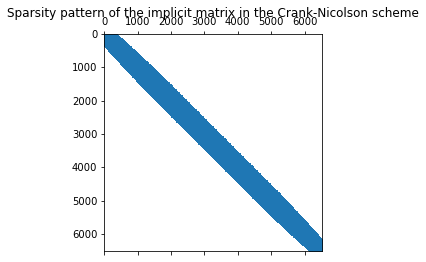

In [7]:
#
# Finite Element Space and Time discretization of the weak formulation
# 
  
# Generate the computational mesh 
# Here is the simplest way to discretize a rectangular domain with nx and ny rectangles in directions x and y,
# respectively. 
# The 'crossed' argument specifies that each rectangle will be divided into four triangles. 

meshing_start         = time.perf_counter()
mesh                  = RectangleMesh(Point(x0,y0), Point(xL,yL), nx, ny,'crossed')
meshing_time          = time.perf_counter()-meshing_start

# If the domain is the unit square, you may want to use instead
# mesh = UnitSquareMesh(nx, ny, 'crossed')
    
# Select the FE approximation space of Lagrange type
V = FunctionSpace(mesh, "Lagrange", deg)
 
#    
# Discretization in space of the weak formulation 
#
assembly_start = time.perf_counter()

u = TrialFunction(V)
v = TestFunction(V)

# Mass matrix
m = u*v*dx
M = assemble(m)

# Stiffness matrix
a = k*inner(grad(u), grad(v))*dx
A = assemble(a)

# Right-hand side (Note that the source term is independent of time here)
F = assemble(f*v*dx)

# Specify the matrices related to the Crank-Nicolson discretization scheme
# The matrices are treated as sparse. 
B = M + theta*dt*A
C = M - (1.-theta)*dt*A

assembly_time = time.perf_counter()-assembly_start

# Construct the solver object related to the implicit part of the time discretization
# We perform here a LU factorization of B.

factorization_start         = time.perf_counter()
Bsolve                      = LUSolver(B)
factorization_time          = time.perf_counter()-factorization_start
Bsolve.parameters["report"] = True

#
# Timings
#

print("Dimension of the implicit matrix in the Crank-Nicolson scheme: ",B.array().shape[:])
print("Number of non-zeros of the implicit matrix: ",B.nnz())
print("Time spent in the meshing procedure: ",meshing_time)
print("Time spent in the finite element assembly procedure: ",assembly_time)
print("Time spent in the LU factorization: ",factorization_time)

#
# Sparsity pattern of B
# 
plt.figure()
plt.spy(sps.csr_matrix(B.array()))
plt.title("Sparsity pattern of the implicit matrix in the Crank-Nicolson scheme")

### Numerical approximation of the space-time solution

In [8]:
#
# Numerical Approximation of the space-time solution
#
t     = tinit
tstep = 0

# Project the initial condition in V
uold  = project(u0, V)

# Store the initial condition if required
uold.rename("u", "Temperature") 
if movie: vtkfile << uold

#
# Time-integration with the Crank-Nicolson scheme
#
unew = Function(V, name="u")
while t + dt <= tfinal:
    t     += dt
    tstep += 1
    
    # Construct the right-hand side of the linear system 
    L      = C*uold.vector() + dt*F
    
    # Solve the linear system to obtain the approximation of the solution at time t
    Bsolve.solve(unew.vector(), L)
    
    # Store the current solution if required
    if movie: vtkfile << unew
        
    # Prepare the next iteration in time 
    uold.assign(unew)
    
    # Monitor the time integration
    if tstep%10 == 0:
       print("Timestep %g"% tstep, "Time %2.3e" %t)

Timestep 10 Time 5.000e-01
Timestep 20 Time 1.000e+00
Timestep 30 Time 1.500e+00
Timestep 40 Time 2.000e+00
Timestep 50 Time 2.500e+00
Timestep 60 Time 3.000e+00
Timestep 70 Time 3.500e+00
Timestep 80 Time 4.000e+00


### Post-processing

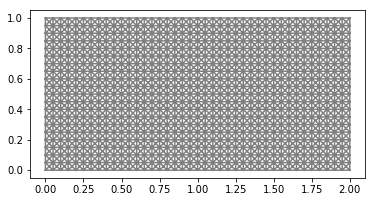

In [9]:
#
# We plot the finite element mesh
# 
plot(mesh)

Text(0.5, 1.0, 'Solution of the heat equation at final time')

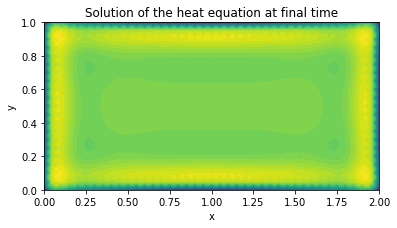

In [10]:
#
# A very basic post-processing
# We plot the solution at final time
#
plt.figure()
plot(unew)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution of the heat equation at final time')
#
# If movie=True, paraview can be used to read the file (evolution of the solution versus time)
#

### Feedback / Your comments or notes

# Further information

- <a href="https://fenicsproject.org">FEniCS website</a>. 

- <a href="https://fenicsproject.org/tutorial">FEniCS tutorials</a>.